## map2loop: Topology fom Local file
This notebook reads in two layers from the local files:  geology polygons and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

In [1]:
import subprocess
import geopandas as gpd
import fiona 
import geoplot
import os
import osgeo 
from osgeo import ogr
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
from shapely.geometry import Polygon

newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
latmin=-23
latmax=-22
longmin=117
longmax=118

step_out=0
minx=500057+step_out    #left hams
maxx=603028-step_out    #right
miny=7455348+step_out   #bottom
maxy=7567953-step_out   #top
src_crs = 'epsg:4326'  #input data coord ref system (assumed to be geodetic lat/long WGS84)
dst_crs = 'epsg:28350' #model ref system (assumed to be something with metre coordinates)

bbox=str(miny)+","+str(minx)+","+str(maxy)+","+str(maxx)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 

print(bbox)

mname='hams2' #root name of model input data

test_data_path='../test_data2/'
strat_graph_file=test_data_path+'graph/output/'+mname+'_strat.gml'

tmp_path=test_data_path+'tmp/'
data_path=test_data_path+'data/'

fault_file=data_path+mname+'_faults.shp'
structure_file=data_path+mname+'_structure.shp'
geology_file=data_path+mname+'_geol.shp'

fault_file_csv=fault_file.replace('shp','csv').replace('/data/','/tmp/')
structure_file_csv=structure_file.replace('shp','csv').replace('/data/','/tmp/')
geology_file_csv=geology_file.replace('shp','csv').replace('/data/','/tmp/')

7455348,500057,7567953,603028


## Plot geology polygons and bounding box

In [3]:
#os.environ

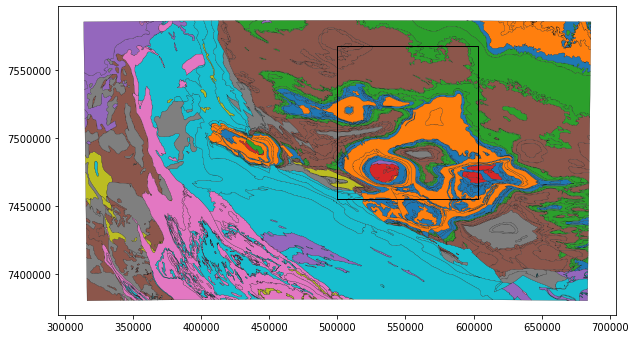

In [4]:
#geology=gpd.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology__DMIRS-014_&BBOX="+bbox+"&srs=EPSG:3857")
#geology=geology['geometry'].intersection(polygon)
#geology_ll = geology.to_crs('epsg:4326')
#print(geology.crs)
geology_ll = gpd.read_file(geology_file)

base=geology_ll.plot(column='CODE',figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')
#print(wfs_geology.head())

## Save to file as WKT

In [5]:
sub_geol = geology_ll[['geometry', 'OBJECTID','CODE','GROUP_','UNITNAME','MIN_AGE_MA','MAX_AGE_MA','DESCRIPTN','ROCKTYPE1','ROCKTYPE2']]

f= open(geology_file_csv,"w+")
f.write("WKT\tOBJECTID\tUNITNAME\tGROUP_\tMIN_AGE_MA\tMAX_AGE_MA\tCODE\tROCKTYPE1\tROCKTYPE2\tDESCRIPTN\n")
        
print(len(sub_geol)," polygons")
#print(sub_geol)
for i in range(0,len(sub_geol)):
    f.write("\""+str(sub_geol.loc[i].geometry)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].OBJECTID)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].CODE)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].GROUP_)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].MIN_AGE_MA)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].MAX_AGE_MA)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].UNITNAME)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].ROCKTYPE1)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].ROCKTYPE2)+"\"\t")
    f.write("\""+str(sub_geol.loc[i].DESCRIPTN)+"\"\n")
    
f.close()


961  polygons


## Read and save WAROX point data as WKT

207  points


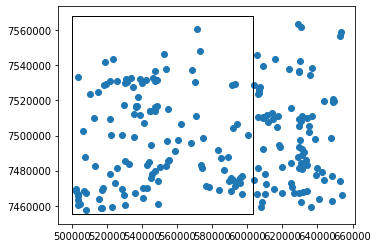

In [6]:
warox = gpd.read_file(structure_file)


sub_pts = warox[['geometry', 'GEOPNT_ID','DIP','DIP_DIR']]

f= open(structure_file_csv,"w+")
f.write("WKT\tGEOPNT_ID\tDIP\tDIP_DIR\n")

print(len(sub_pts)," points")


#for i in range(0,len(sub_pts)):
#    for j in range(0,len(sub_geol)):
#        if(sub_pts.loc[i].geometry.within(sub_geol.loc[j].geometry)):
#            print(i,j)

for i in range(0,len(sub_pts)):
    line="\""+str(sub_pts.loc[i].geometry)+"\"\t\""+str(sub_pts.loc[i].GEOPNT_ID)+"\"\t\""+\
      str(sub_pts.loc[i].DIP)+"\"\t\""+str(sub_pts.loc[i].DIP_DIR)+"\"\n"    
    f.write(functools.reduce(operator.add, (line)))
    
f.close()

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

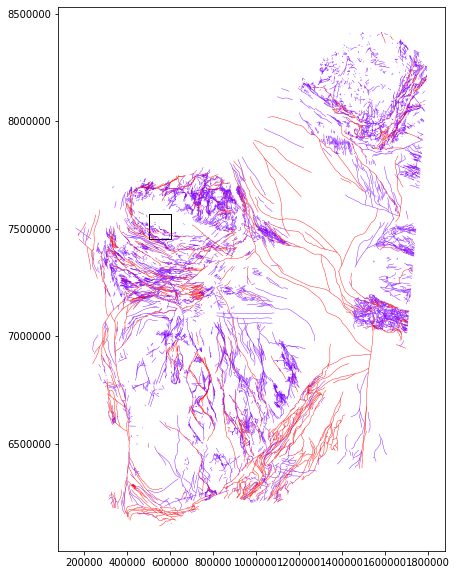

In [7]:
#bbox='-23,117,-22,118'
#lines=gpd.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology_structural_lines__DMIRS-013_&BBOX="+bbox+"&srs=EPSG:3857")
#print(lines)
#lines.plot(column='feature',figsize=(10,10),linewidth=0.2)
lines_ll=gpd.read_file(fault_file)
#lines_ll = lines.to_crs('epsg:4326')
#print(geology.crs)
base2=lines_ll.plot(cmap='rainbow',column='FEATURE',figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [8]:
sub_lines = lines_ll[['geometry', 'OBJECTID','FEATURE']]

f= open(fault_file_csv,"w+")
f.write("WKT\tOBJECTID\tFEATURE\n")

print(len(sub_lines)," polylines")

for i in range(0,len(sub_lines)):
    f.write("\""+str(sub_lines.loc[i].geometry)+"\"\t")
    f.write("\""+str(sub_lines.loc[i].OBJECTID)+"\"\t")
    f.write("\""+str(sub_lines.loc[i].FEATURE)+"\"\n")
    
f.close()

15204  polylines


## Create map2model input file

In [9]:
f=open('../test_data2/tmp/Parfile','w')
f.write('--- COLUMN NAMES IN CSV DATA FILES: -------------------------------------------------------------\n')
f.write('OBJECT COORDINATES              =WKT\n')
f.write('FAULT: ID                       =OBJECTID\n')
f.write('FAULT: FEATURE                  =FEATURE\n')
f.write('POINT: ID                       =GEOPNT_ID\n')
f.write('POINT: DIP                      =DIP\n')
f.write('POINT: DIP DIR                  =DIP_DIR\n')
f.write('POLYGON: ID                     =OBJECTID\n')
f.write('POLYGON: LEVEL1 NAME            =UNITNAME\n')
f.write('POLYGON: LEVEL2 NAME            =GROUP_\n')
f.write('POLYGON: MIN AGE                =MIN_AGE_MA\n')
f.write('POLYGON: MAX AGE                =MAX_AGE_MA\n')
f.write('POLYGON: CODE                   =CODE\n')
f.write('POLYGON: DESCRIPTION            =DESCRIPTN\n')
f.write('POLYGON: ROCKTYPE1              =ROCKTYPE1\n')
f.write('POLYGON: ROCKTYPE2              =ROCKTYPE2\n')
f.write('--- SOME CONSTANTS: ----------------------------------------------------------------------------\n')
f.write('FAULT AXIAL FEATURE NAME        =Fold axial trace\n')
f.write('SILL UNIT DESCRIPTION CONTAINS  =sills\n')
f.write('------------------------------------------------------------------------------------------------\n')
f.write('Path to the output data folder                      =../test_data2/graph/output\n')
f.write('Path to geology data file                           ='+geology_file_csv+'\n')
f.write('Path to faults data file                            ='+fault_file_csv+'\n')
f.write('Path to points data file                            ='+structure_file_csv+'\n')
f.write('------------------------------------------------------------------------------------------------\n')
f.write('Clipping window X1 Y1 X2 Y2 (zeros for infinite)    ='+str(minx)+' '+str(miny)+' '+str(maxx)+' '+str(maxy)+'\n')
f.write('Min length fraction for strat/fault graphs          =0.0\n')
f.write('Graph edge width categories (three doubles)         =2000. 20000. 200000.\n')
f.write('Graph edge direction (0-min age, 1-max age, 2-avg)  =0\n')
f.write('Partial graph polygon ID                            =32\n')
f.write('Partial graph depth                                 =4\n')
f.write('Map subregion size dx, dy [m] (zeros for full map)  =0. 0.\n')
f.write('------------------------------------------------------------------------------------------------\n')
f.close()



## Calculate topology

In [14]:
os.chdir('../m2m_cpp')
print(os.getcwd())
subprocess.run(["map2model_vsc.exe", "../test_data2/tmp/Parfile"],shell = True)

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


CompletedProcess(args=['map2model_vsc.exe', '../test_data2/tmp/Parfile'], returncode=0)

## Simple network graph of the geology with legend

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


0    'A-HAm-cib'
1    'A-FOp-bs'
2    'A-HAS-xsl-ci'
3    'P_-HAb-cib'
4    'P_-HAj-xci-od'
5    'A-mgn-PRK'
6    'A-FOh-xs-f'
7    'A-FOo-bbo'
8    'A-FO-od'
9    'A-HAd-kd'
10    'A-FOj-xs-b'
11    'P_-TKa-xs-k'
12    'P_-HAo-ci'
13    'P_-HAw-fr'
14    'A-FO-xo-a'
15    'A-b-PRK'
16    'A-FOr-b'
17    'A-FOu-bbo'
18    'P_-TK-s'
19    'A-mgn-PMI'
20    'A-s-PMI'
21    'A-s-PRK'
22    'P_-SKq-stq'
23    'P_-WYm-sp'
24    'P_-WYa-st'
25    'P_-WYd-kd'
26    'P_-TKo-stq'
27    'P_-TKk-sf'
28    'P_-SKb-bb'


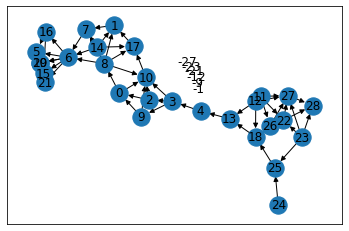

In [11]:
G=nx.read_gml("../test_data2/graph/output/graph_strat.gml",label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Topology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

In [12]:
from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

FileNotFoundError: [Errno 2] No such file or directory: ''

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/2.%20map2loop_after_topology.ipynb